# cgl1 1-parameter Bifurcation Diagrams

diagram data from XPP. The file is `/xpp/cgl1.ode`, and the data is saved to `/bif_cgl1` with the file name...

`par1_nm_negative.dat`

`1` can be `2`, `nm` denotes n:m, `negative` can be `positive`.

# Inits

In [1]:
def g3(x):
    return np.exp(np.cos(x))

In [2]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import cgl1 as c1
from lib.functions import g1,p,g3

from lib.util import (get_phase, _get_sol,load_bif1d_f,load_phis_force,load_bif1d_f_u,load_phis_force,load_phis_force_u,run_bif1d_f_u)

from generate_figures import _full_cgl1, _cgl1_aut

from lib.rhs import _redu_c, _full, rhs_avg_1df
from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined,
                           add_diagram_full, add_diagram_1d,
                           load_diagram_full_f)

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

In [3]:
# # compare g3 with von Mises.
# pbar = 1.266065877752
# fig,axs = plt.subplots(figsize=(6,2))
# x = np.linspace(0,4*np.pi,1000)
# axs.plot(x,-(g3(x)/2.7)**3,label='exp(cos)')
# axs.plot(x,g1(x),label='vM')
# axs.legend()

In [4]:
def g4(x):
    return (g3(x)/2.7)**3

## Dicts

In [5]:
kw_sim = {'rtol':1e-9,'atol':1e-9,'method':'LSODA'}

In [6]:

kws1 = {'var_names':['x','y'],
        'init':np.array([1,0,2*np.pi]),
        'TN':2000,
        'idx':0,
        'model_name':'cglf0',
        'trunc_order':1,
        'recompute_list':[],
        'g_forward':False,
        'z_forward':False,
        'i_forward':[False,True,True,True,True,True,True],
        'i_bad_dx':[False,True,False,False,False,False,False],
        'max_iter':20,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'forcing_fn':[lambda x: -g4(x),lambda x:20*(g4(x+2))],
        #'forcing_fn':[g1,lambda x:-20*g1(x+1)],
        #'forcing_fn':[np.cos,lambda x:20*np.cos(x+1)], # function or list. List if using higher-order terms
        #'forcing_fn':[lambda x:-np.cos(x),lambda x:20*np.cos(x+1)],
        'rhs':c1.rhs_old2}

In [7]:
pd_cgl_template = {'sig':.08,'rho':.12,'mu':1,'om':1,'om_fix':1}

In [8]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-10,'atol':1e-10}

## Defs

## Initialize Response Functions

In [9]:
system1 = rsp(**{'pardict':pd_cgl_template,**kws1})

mkdir ./data/cglf0/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0000000000003393
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.1600000002125898
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


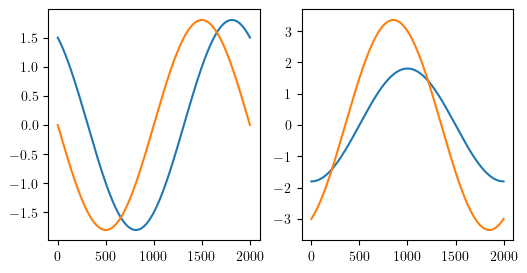

In [10]:
fig,axs = plt.subplots(1,2,figsize=(6,3))
for k in range(system1.miter):
    axs[0].plot(system1.z['dat'][k][:,0])

for k in range(system1.miter):
    axs[1].plot(system1.i['dat'][k][:,0])

# 1:1

In [11]:
recompute_list = ['h_data_cglf0','h_cglf0','p_cglf0','p_data_cglf0','k_cglf0','k_cglf1']
#recompute_list = []
kw_nm = {'system1':system1,'system2':None,'_n':('om0',1),'_m':('om1',1),
         'NH':500,'save_fig':False,'recompute_list':recompute_list}

## del=0.0

In [12]:
del11_p0 = 0
a11_p0 = nm.nmCoupling(**kw_nm)
a11_p0.del1 = del11_p0

Initializing 11 Coupling...
* Loading p...
p order=0
* Computing H cglf0, order=0...
p order=1
* Computing H cglf0, order=1...


### H functions

In [13]:
# aa = a11_p0
# fig,axs = plt.subplots(aa.system1.miter+1,1,figsize=(6,3))
# if aa.system1.miter == 1:
#     axs = np.asarray([axs])
# etemp = .1
# h = 0
# for k in range(aa.system1.miter):
#     axs[k].plot(aa.x,aa.system1.h['lam'][k](aa.x))
#     h += etemp**(k+1)*aa.system1.h['lam'][k](aa.x)

# axs[-1].plot(aa.x,h)
# plt.tight_layout()

### Newton summary

The workflow is as follows.

For a given eps, delta:
1. Obtain an initial guess for the solution using a given initial phase.
2. Run Newton's method to see if it converges or not
    * If it converges:
        1. Obtain the initial condition needed to start in the phase-locked state
        2. After all initial conditions are obtained, use `get_period_all` to get phase differences
    * If it does not converge:
        2. Pass or save nan.

### Plot 1par

In [14]:
etup = (.002,.21,.01)
out = load_bif1d_f(_full_cgl1,a11_p0,del11_p0,etup=etup)

In [15]:
erange = out[:,0]
inits = out[:,1:]

In [16]:
philist = load_phis_force(_full_cgl1,a11_p0,del11_p0,etup=etup,period_multiple=10)

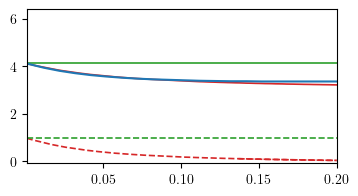

In [17]:
fig,axs = plt.subplots(figsize=(4,2))

add_diagram_1d(axs,a11_p0,del11_p0,(.001,.2,200),rhs=rhs_avg_1df)
add_diagram_1d(axs,a11_p0,del11_p0,(.001,.2,200),rhs=rhs_avg_1df,miter=1,color='tab:green')

axs.plot(erange,np.mod(-philist,2*np.pi))

### Unstable

In [18]:
etupu = (.03,0,-.01)
phi0 = 1
out = load_bif1d_f_u(_full_cgl1,a11_p0,del11_p0,etup=etupu,phi0=phi0)
philist = load_phis_force_u(_full_cgl1,a11_p0,del11_p0,etup=etupu,period_multiple=10,phi0=phi0)
np.mod(-philist,2*np.pi)

array([0.58866776, 0.68866776, 0.82185307])

### Sims

In [19]:
# coupling and init
eps11_p0 = .1
th_init11_p0 = 1

In [20]:
# sim params
dt = .01;T_p00=100
t11_p0 = np.arange(0,T_p00,dt)
args11_p0 = {'args':(a11_p0,eps11_p0,del11_p0),'t_eval':t11_p0,**kw_sim,'dense_output':True}

In [21]:
y0_p00 = a11_p0.system1.lc['dat'][int((th_init11_p0/(2*np.pi))*a11_p0.system1.TN),:]
args0 = [a11_p0,eps11_p0,del11_p0]

solf = _get_sol(_full_cgl1,y0_p00,t11_p0,args=args0,recompute=True)        
tp,fp = get_phase(t11_p0,solf,skipn=100,system1=a11_p0.system1)
force_phase = (a11_p0._m[1]+del11_p0)*tp
fp2 = np.mod(fp-a11_p0.om*force_phase,2*np.pi)

args0 = [a11_p0,eps11_p0,del11_p0]
args1 = {'t_eval':t11_p0,'t_span':[0,t11_p0[-1]],'args':(*args0,),**kw_sim}
solr1d = solve_ivp(rhs_avg_1df,y0=[th_init11_p0],**args1)

args0 = [a11_p0,eps11_p0,del11_p0,1]
args1 = {'t_eval':t11_p0,'t_span':[0,t11_p0[-1]],'args':(*args0,),**kw_sim}
solr1d0 = solve_ivp(rhs_avg_1df,y0=[th_init11_p0],**args1)

### Plot Sims

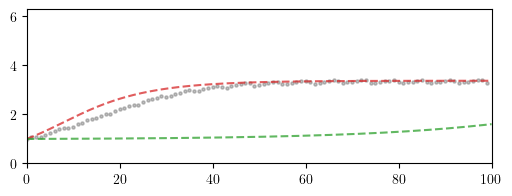

In [22]:
fig,axs = plt.subplots(1,1,figsize=(6,2))

# plot full sol
axs.scatter(tp,fp2,s=5,color='gray',alpha=.5,label='Full')
axs.set_ylim(0,2*np.pi)
axs.set_xlim(0,T_p00)

# 1d solution over time
axs.plot(t11_p0,np.mod(solr1d.y.T[:,0],2*np.pi),color='tab:red',alpha=.75,label='1D',ls='--')
axs.plot(t11_p0,np.mod(solr1d0.y.T[:,0],2*np.pi),color='tab:green',alpha=.75,label='1D',ls='--')

## del=0.02

In [23]:
del11_p1 = 0.02
a11_p1 = nm.nmCoupling(**kw_nm)
a11_p1.del1 = del11_p1

Initializing 11 Coupling...
* Loading p...
p order=0
* Computing H cglf0, order=0...
p order=1
* Computing H cglf0, order=1...


### H functions

In [24]:
# aa = a11_p1
# fig,axs = plt.subplots(aa.system1.miter+1,1,figsize=(6,3))
# axs = np.asarray(axs)
# etemp = .5
# h = 0
# for k in range(aa.system1.miter):
#     axs[k].plot(aa.x,aa.system1.h['lam'][k](aa.x))
#     h += etemp**(k+1)*aa.system1.h['lam'][k](aa.x)

# axs[-1].plot(h)
    
# plt.tight_layout()

### Plot 1par

In [25]:
etup = (.04,.2,.001)
out = load_bif1d_f(_full_cgl1,a11_p1,del11_p1,etup=etup,max_iter=20)

In [26]:
erange = out[:,0]
inits = out[:,1:]

In [27]:
out.shape

(160, 3)

In [28]:
philist = load_phis_force(_full_cgl1,a11_p1,del11_p1,etup=etup,period_multiple=10)

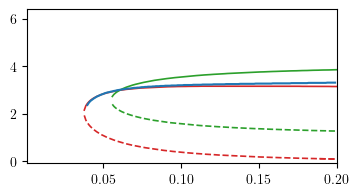

In [29]:
fig,axs = plt.subplots(figsize=(4,2))

add_diagram_1d(axs,a11_p1,del11_p1,(.001,.2,200),rhs=rhs_avg_1df)
add_diagram_1d(axs,a11_p1,del11_p1,(.001,.2,200),rhs=rhs_avg_1df,miter=1,color='tab:green')

axs.plot(erange,np.mod(-philist,2*np.pi))

### Unstable

In [30]:
etupu = (.03,0,-.01)
phi0 = 1
out = load_bif1d_f_u(_full_cgl1,a11_p0,del11_p0,etup=etupu,phi0=phi0)
philist = load_phis_force_u(_full_cgl1,a11_p0,del11_p0,etup=etupu,period_multiple=10,phi0=phi0)
print('phi',np.mod(-philist,2*np.pi)[0])
print('y',out[0])

etupu = (.05,.03,-.01)
phi0 = .5
dd = 0.002
out = load_bif1d_f_u(_full_cgl1,a11_p0,dd,etup=etupu,phi0=phi0,use_point=out[0][1:],recompute=False)
philist = load_phis_force_u(_full_cgl1,a11_p0,dd,etup=etupu,period_multiple=10,use_point=out[0][1:],phi0=phi0,recompute=False)
print('phi',np.mod(-philist,2*np.pi)[0])
print('y',out[0])

etupu = (.05,.03,-.01)
phi0 = .5
dd = 0.01
out = load_bif1d_f_u(_full_cgl1,a11_p0,dd,etup=etupu,phi0=phi0,use_point=out[0][1:],recompute=False)
philist = load_phis_force_u(_full_cgl1,a11_p0,dd,etup=etupu,period_multiple=10,use_point=out[0][1:],phi0=phi0,recompute=False)
print('phi',np.mod(-philist,2*np.pi)[0])
print('y',out[0])


etupu = (.05,.03,-.01)
phi0 = .5
dd = 0.015
out = load_bif1d_f_u(_full_cgl1,a11_p0,dd,etup=etupu,phi0=phi0,use_point=out[0][1:],recompute=False)
philist = load_phis_force_u(_full_cgl1,a11_p0,dd,etup=etupu,period_multiple=10,use_point=out[0][1:],phi0=phi0,recompute=False)
print('phi',np.mod(-philist,2*np.pi)[0])
print('y',out[0])

phi 0.5886677646162752
y [0.03       0.81352605 0.52179603]
phi 0.6186677646162764
y [0.05       0.83353305 0.43077119]
phi 1.3718530717958615
y [0.05       0.71454989 0.65217436]
phi 1.8418530717958603
y [0.05       0.59423526 0.78924236]


<Axes: >

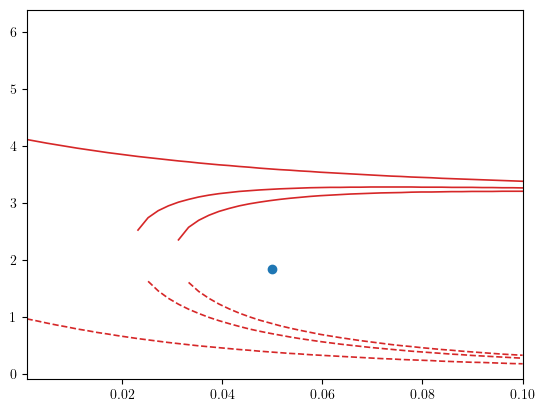

In [31]:
fig,axs = plt.subplots()
axs.scatter([out[0,0]],[np.mod(-philist[0],2*np.pi)])
add_diagram_1d(axs,a11_p1,.0,(.001,.1,50),rhs=rhs_avg_1df)
add_diagram_1d(axs,a11_p1,.01,(.001,.1,50),rhs=rhs_avg_1df)
add_diagram_1d(axs,a11_p1,.015,(.001,.1,50),rhs=rhs_avg_1df)

### Sims

In [32]:
# coupling and init
eps11_p1 = 0.11
th_init11_p1 = 2

In [33]:
# sim params
dt = .01;T_p050=500
t11_p1 = np.arange(0,T_p050,dt)
args11_p1 = {'args':(a11_p1,eps11_p1,del11_p1),'t_eval':t11_p1,**kw_sim,'dense_output':True}

In [34]:
y0_p050 = a11_p1.system1.lc['dat'][int((th_init11_p1/(2*np.pi))*a11_p1.system1.TN),:]
args0 = [a11_p1,eps11_p1,del11_p1]

solf = _get_sol(_full_cgl1,y0_p050,t11_p1,args=args0,recompute=True)        
tp,fp = get_phase(t11_p1,solf,skipn=100,system1=a11_p1.system1)
force_phase = (a11_p1._m[1]+del11_p1)*tp
fp2 = np.mod(fp-a11_p1.om*force_phase,2*np.pi)

args1 = {'t_eval':t11_p1,'t_span':[0,t11_p1[-1]],'args':(*args0,),**kw_sim}
solr1d = solve_ivp(rhs_avg_1df,y0=[th_init11_p1],**args1)

args0 = [a11_p1,eps11_p1,del11_p1,1]
args1 = {'t_eval':t11_p1,'t_span':[0,t11_p1[-1]],'args':(*args0,),**kw_sim}
solr1d0 = solve_ivp(rhs_avg_1df,y0=[th_init11_p1],**args1)

### Plot Sim

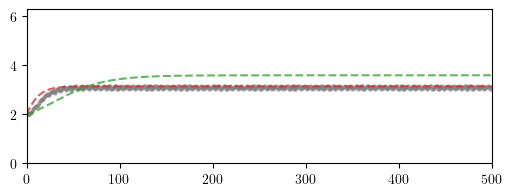

In [35]:
fig,axs = plt.subplots(1,1,figsize=(6,2))

# plot full sol
axs.scatter(tp,fp2,s=5,color='gray',alpha=.5,label='Full')
axs.set_ylim(0,2*np.pi)
axs.set_xlim(0,T_p050)

# 1d solution over time
axs.plot(t11_p1,np.mod(solr1d.y.T[:,0],2*np.pi),color='tab:red',alpha=.75,label='1D',ls='--')
axs.plot(t11_p1,np.mod(solr1d0.y.T[:,0],2*np.pi),color='tab:green',alpha=.75,label='1D',ls='--')

# 2:1

In [36]:
#recompute_list = ['h_data_cglf0','h_cglf0','p_cglf0','p_data_cglf0','k_cglf0','k_cglf1']
#recompute_list = []
kw_nm = {'system1':system1,'system2':None,'_n':('om0',2),'_m':('om1',1),
         'NH':300,'save_fig':False,'recompute_list':recompute_list}

## del=0.0

In [101]:
del21_p0 = 0.0
a21_p0 = nm.nmCoupling(**kw_nm)
a21_p0.del1=del21_p0

Initializing 21 Coupling...
* Loading p...
p order=0
* Computing H cglf0, order=0...
p order=1
* Computing H cglf0, order=1...


### H functions

In [102]:
# aa = a21_p0
# fig,axs = plt.subplots(aa.system1.miter,1,figsize=(6,3))
# etemp = .05
# h = 0
# for k in range(aa.system1.miter):
#     axs[k].plot(aa.x,etemp**(k+1)*aa.system1.h['lam'][k](aa.x))
    
# plt.tight_layout()

### Plot 1par

In [103]:
out = load_bif1d_f(_full_cgl1,a21_p0,del21_p0,etup=(.002,.21,.01),max_iter=20)

In [104]:
erange = out[:,0]
inits = out[:,1:]

In [105]:
philist = load_phis_force(_full_cgl1,a21_p0,del21_p0,etup=(.002,.21,.01),period_multiple=10)

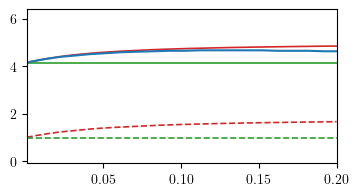

In [106]:
fig,axs = plt.subplots(figsize=(4,2))

add_diagram_1d(axs,a21_p0,del21_p0,(.001,.2,200),rhs=rhs_avg_1df)
add_diagram_1d(axs,a21_p0,del21_p0,(.001,.2,200),rhs=rhs_avg_1df,miter=1,color='tab:green')

axs.plot(erange,np.mod(-philist,2*np.pi))

### Unstable

In [108]:
etupu = (.001,0,-.0005)
phi0 = 0
dd = 0
out = load_bif1d_f_u(_full_cgl1,a21_p0,dd,etup=etupu,phi0=phi0,recompute=False)
philist = load_phis_force_u(_full_cgl1,a21_p0,dd,etup=etupu,period_multiple=10,phi0=phi0,recompute=False)
print('phi',np.mod(-philist,2*np.pi)[0])
print('y',out[0])

etupu = (.002,0,-.001)
phi0 = 0
dd = 0
out = load_bif1d_f_u(_full_cgl1,a21_p0,dd,etup=etupu,recompute=False,use_point=out[0][1:])
philist = load_phis_force_u(_full_cgl1,a21_p0,dd,etup=etupu,period_multiple=10,recompute=False,use_point=out[0][1:])
print('phi',np.mod(-philist,2*np.pi)[0])
print('y',out[0])

etupu = (.003,0,-.001)
phi0 = 0
dd = 0
out = load_bif1d_f_u(_full_cgl1,a21_p0,dd,etup=etupu,recompute=False,use_point=out[0][1:])
philist = load_phis_force_u(_full_cgl1,a21_p0,dd,etup=etupu,period_multiple=10,recompute=False,use_point=out[0][1:])
print('phi',np.mod(-philist,2*np.pi)[0])
print('y',out[0])

etupu = (.004,0,-.001)
phi0 = 0
dd = 0
out = load_bif1d_f_u(_full_cgl1,a21_p0,dd,etup=etupu,recompute=False,use_point=out[0][1:])
philist = load_phis_force_u(_full_cgl1,a21_p0,dd,etup=etupu,period_multiple=10,recompute=False,use_point=out[0][1:])
print('phi',np.mod(-philist,2*np.pi)[0])
print('y',out[0])


etupu = (.005,0,-.001)
phi0 = 0
dd = 0
out = load_bif1d_f_u(_full_cgl1,a21_p0,dd,etup=etupu,recompute=False,use_point=out[0][1:])
philist = load_phis_force_u(_full_cgl1,a21_p0,dd,etup=etupu,period_multiple=10,recompute=False,use_point=out[0][1:])
print('phi',np.mod(-philist,2*np.pi)[0])
print('y',out[0])


etupu = (.007,.005,-.001)
phi0 = 0
dd = 0
out = load_bif1d_f_u(_full_cgl1,a21_p0,dd,etup=etupu,recompute=False,use_point=out[0][1:])
philist = load_phis_force_u(_full_cgl1,a21_p0,dd,etup=etupu,period_multiple=10,recompute=False,use_point=out[0][1:])
print('phi',np.mod(-philist,2*np.pi)[0])
print('y',out[0])


etupu = (.01,.007,-.001)
phi0 = 0
dd = 0
out = load_bif1d_f_u(_full_cgl1,a21_p0,dd,etup=etupu,recompute=False,use_point=out[0][1:])
philist = load_phis_force_u(_full_cgl1,a21_p0,dd,etup=etupu,period_multiple=10,recompute=False,use_point=out[0][1:])
print('phi',np.mod(-philist,2*np.pi)[0])
print('y',out[0])


etupu = (.015,.007,-.001)
phi0 = 0
dd = 0
out = load_bif1d_f_u(_full_cgl1,a21_p0,dd,etup=etupu,recompute=False,use_point=out[0][1:])
philist = load_phis_force_u(_full_cgl1,a21_p0,dd,etup=etupu,period_multiple=10,recompute=False,use_point=out[0][1:])
print('phi',np.mod(-philist,2*np.pi)[0])
print('y',out[0])


etupu = (.02,.007,-.001)
phi0 = 0
dd = 0
out = load_bif1d_f_u(_full_cgl1,a21_p0,dd,etup=etupu,recompute=False,use_point=out[0][1:])
philist = load_phis_force_u(_full_cgl1,a21_p0,dd,etup=etupu,period_multiple=10,recompute=False,use_point=out[0][1:])
print('phi',np.mod(-philist,2*np.pi)[0])
print('y',out[0])


etupu = (.03,.007,-.001)
phi0 = 0
dd = 0
out = load_bif1d_f_u(_full_cgl1,a21_p0,dd,etup=etupu,recompute=False,use_point=out[0][1:])
philist = load_phis_force_u(_full_cgl1,a21_p0,dd,etup=etupu,period_multiple=10,recompute=False,use_point=out[0][1:])
print('phi',np.mod(-philist,2*np.pi)[0])
print('y',out[0])


etupu = (.04,.02,-.01)
phi0 = 0
dd = 0
out = load_bif1d_f_u(_full_cgl1,a21_p0,dd,etup=etupu,recompute=False,use_point=out[0][1:])
philist = load_phis_force_u(_full_cgl1,a21_p0,dd,etup=etupu,period_multiple=10,recompute=False,use_point=out[0][1:])
print('phi',np.mod(-philist,2*np.pi)[0])
print('y',out[0])

init_21_p0 = out[0][1:]

phi 1.003706143591728
y [0.001      0.54185823 0.83914281]
phi 1.003706143591728
y [0.002      0.52922708 0.84582458]
phi 1.023706143591724
y [0.003      0.51681172 0.85211254]
phi 1.04370614359172
y [0.004      0.50461466 0.85802407]
phi 1.0637061435917161
y [0.005      0.49263762 0.86357595]
phi 1.0837061435917263
y [0.007      0.46934684 0.87366471]
phi 1.1237061435917184
y [0.01       0.43606382 0.88648461]
phi 1.1637061435917246
y [0.015      0.38488937 0.90256847]
phi 1.223706143591727
y [0.02       0.33877521 0.91325821]
phi 1.3037061435917252
y [0.03       0.25987772 0.9226373 ]
phi 1.3637061435917275
y [0.04       0.19557787 0.92066561]


### Sims

In [60]:
# coupling and init
eps21_p0 = 0.1
th_init21_p0 = 2

In [61]:
# sim params
dt = .01;T_p01=100
t21_p0 = np.arange(0,T_p01,dt)
args21_p0 = {'args':(a21_p0,eps21_p0,del21_p0),'t_eval':t21_p0,**kw_sim,'dense_output':True}

In [62]:
y0_p01 = a21_p0.system1.lc['dat'][int((th_init21_p0/(2*np.pi))*a21_p0.system1.TN),:]
args0 = [a21_p0,eps21_p0,del21_p0]

solf = _get_sol(_full_cgl1,y0_p01,t21_p0,args=args0,recompute=True)        
tp,fp = get_phase(t21_p0,solf,skipn=100,system1=a21_p0.system1)
force_phase = (a21_p0._m[1]+del21_p0)*tp
fp2 = np.mod(fp-a21_p0.om*force_phase,2*np.pi)

args1 = {'t_eval':t21_p0,'t_span':[0,t21_p0[-1]],'args':(*args0,),**kw_sim}
solr1d = solve_ivp(rhs_avg_1df,y0=[th_init21_p0],**args1)

args0 = [a21_p0,eps21_p0,del21_p0,1]
args1 = {'t_eval':t21_p0,'t_span':[0,t21_p0[-1]],'args':(*args0,),**kw_sim}
solr1d0 = solve_ivp(rhs_avg_1df,y0=[th_init21_p0],**args1)

### Plot Sims

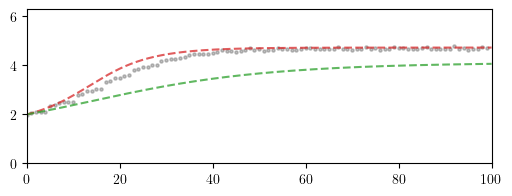

In [63]:
fig,axs = plt.subplots(1,1,figsize=(6,2))

# plot full sol
axs.scatter(tp,fp2,s=5,color='gray',alpha=.5,label='Full')
axs.set_ylim(0,2*np.pi)
axs.set_xlim(0,T_p01)

# 1d solution over time
axs.plot(t21_p0,np.mod(solr1d.y.T[:,0],2*np.pi),color='tab:red',alpha=.75,label='1D',ls='--')
axs.plot(t21_p0,np.mod(solr1d0.y.T[:,0],2*np.pi),color='tab:green',alpha=.75,label='1D',ls='--')

## del=0.001

In [95]:
del21_p1b = .001
a21_p1b = nm.nmCoupling(**kw_nm)
a21_p1b.del1=del21_p1b

Initializing 21 Coupling...
* Loading p...
p order=0
* Computing H cglf0, order=0...
p order=1
* Computing H cglf0, order=1...


<Axes: >

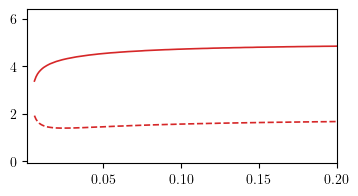

In [96]:
fig,axs = plt.subplots(figsize=(4,2))
add_diagram_1d(axs,a21_p1b,del21_p1b,(.001,.2,200),rhs=rhs_avg_1df)

In [113]:
init0 = np.array([0.19557787, 0.92066561])
etupu = (.04,.03,-.01)
phi0 = 2
out = load_bif1d_f_u(_full_cgl1,a21_p1b,del21_p1b,etup=etupu,phi0=phi0,recompute=True,use_point=init0)
philist = load_phis_force_u(_full_cgl1,a21_p1b,del21_p1b,etup=etupu,period_multiple=10,phi0=phi0,recompute=True,use_point=init0)
print('phi',np.mod(-philist,2*np.pi)[0])
print('y',out[0])

# etupu = (.0,.0,-.005)
# phi0 = 2
# out = load_bif1d_f_u(_full_cgl1,a21_p1b,del21_p1b,etup=etupu,phi0=phi0,recompute=True,use_point=out[0][1:])
# philist = load_phis_force_u(_full_cgl1,a21_p1b,del21_p1b,etup=etupu,period_multiple=10,phi0=phi0,recompute=True,use_point=out[0][1:])
# print('phi',np.mod(-philist,2*np.pi)[0])
# print('y',out[0])

phi0 in run_bif1d_f 2
yprev,est [0.12716705 0.93661341] [0.12716705 0.93661341]
0, eps=0.040 [0.12716705 0.93661341]
yprev,est [0.15633501 0.94952713] [0.15633501 0.94952713]
1, eps=0.030 [0.15633501 0.94952713]
phi0 in run_bif1d_f 2
yprev,est [0.12716705 0.93661341] [0.12716705 0.93661341]
0, eps=0.040 [0.12716705 0.93661341]
yprev,est [0.15633501 0.94952713] [0.15633501 0.94952713]
1, eps=0.030 [0.15633501 0.94952713]
phi 1.4444448840148976
y [0.04       0.12716705 0.93661341]


## del=0.0025

In [116]:
del21_p1b = .0025
a21_p1b = nm.nmCoupling(**kw_nm)
a21_p1b.del1=del21_p1b

Initializing 21 Coupling...
* Loading p...
p order=0
* Computing H cglf0, order=0...
p order=1
* Computing H cglf0, order=1...


<Axes: >

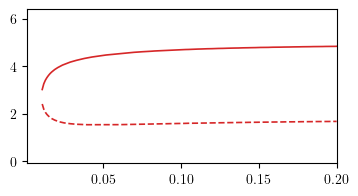

In [117]:
fig,axs = plt.subplots(figsize=(4,2))
add_diagram_1d(axs,a21_p1b,del21_p1b,(.001,.2,200),rhs=rhs_avg_1df)

In [118]:
init0 = np.array([0.12716705, 0.93661341])
etupu = (.04,.02,-.01)
phi0 = 1.9
out = load_bif1d_f_u(_full_cgl1,a21_p1b,del21_p1b,etup=etupu,recompute=True,use_point=init0)
philist = load_phis_force_u(_full_cgl1,a21_p1b,del21_p1b,etup=etupu,period_multiple=10,recompute=True,use_point=init0)
print('phi',np.mod(-philist,2*np.pi)[0])
print('y',out[0])

phi0 in run_bif1d_f 0
yprev,est [0.02051835 0.95159539] [0.02051835 0.95159539]
0, eps=0.040 [0.02051835 0.95159539]
yprev,est [-0.00818267  0.96892399] [-0.00818267  0.96892399]
1, eps=0.030 [-0.00818267  0.96892399]
phi0 in run_bif1d_f 0
yprev,est [0.02051837 0.95159539] [0.02051837 0.95159539]
0, eps=0.040 [0.02051837 0.95159539]
yprev,est [-0.00818267  0.96892399] [-0.00818267  0.96892399]
1, eps=0.030 [-0.00818267  0.96892399]
phi 1.5459991090869574
y [0.04       0.02051835 0.95159539]


## del=0.005

In [119]:
del21_p1b = .005
a21_p1b = nm.nmCoupling(**kw_nm)
a21_p1b.del1=del21_p1b

Initializing 21 Coupling...
* Loading p...
p order=0
* Computing H cglf0, order=0...
p order=1
* Computing H cglf0, order=1...


<Axes: >

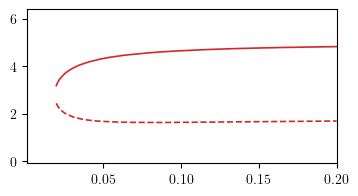

In [120]:
fig,axs = plt.subplots(figsize=(4,2))
add_diagram_1d(axs,a21_p1b,del21_p1b,(.001,.2,200),rhs=rhs_avg_1df)

In [122]:
init0 = np.array([0.02051835, 0.95159539])
etupu = (.04,.02,-.01)
phi0 = 1.9
out = load_bif1d_f_u(_full_cgl1,a21_p1b,del21_p1b,etup=etupu,recompute=True,use_point=init0)
philist = load_phis_force_u(_full_cgl1,a21_p1b,del21_p1b,etup=etupu,period_multiple=10,recompute=True,use_point=init0)
print('phi',np.mod(-philist,2*np.pi)[0])
print('y',out[0])

phi0 in run_bif1d_f 0
yprev,est [-0.16936787  0.94961894] [-0.16936787  0.94961894]
0, eps=0.040 [-0.16936787  0.94961894]
yprev,est [-0.31245478  0.93219117] [-0.31245478  0.93219117]
1, eps=0.030 [-0.31245478  0.93219117]
phi0 in run_bif1d_f 0
yprev,est [-0.16936787  0.94961895] [-0.16936787  0.94961895]
0, eps=0.040 [-0.16936787  0.94961895]
yprev,est [-0.31245478  0.93219117] [-0.31245478  0.93219117]
1, eps=0.030 [-0.31245478  0.93219117]
phi 1.749773204107095
y [ 0.04       -0.16936787  0.94961894]


## del=0.01

In [66]:
del21_p1 = .01
a21_p1 = nm.nmCoupling(**kw_nm)
a21_p1.del1=del21_p1

Initializing 21 Coupling...
* Loading p...
p order=0
* Computing H cglf0, order=0...
p order=1
* Computing H cglf0, order=1...


### H functions

In [67]:
# aa = a21_p1
# fig,axs = plt.subplots(aa.system1.miter+1,1,figsize=(6,3))
# etemp = .01
# h = 0
# for k in range(aa.system1.miter):
#     axs[k].plot(aa.x,etemp**(k+1)*aa.system1.h['lam'][k](aa.x))
#     h += etemp**(k+1)*aa.system1.h['lam'][k](aa.x)

# axs[-1].plot(h)
# plt.tight_layout()

### Plot 1par

In [69]:
out = load_bif1d_f(_full_cgl1,a21_p1,del21_p1,etup=(.070,.201,.001),max_iter=20)

phi0 in run_bif1d_f 0
0, eps=0.070 [-0.46952026 -1.02956467]
1, eps=0.071 [-0.45932744 -1.03599971]
2, eps=0.072 [-0.44939405 -1.04217341]
3, eps=0.073 [-0.43971152 -1.04810164]
4, eps=0.074 [-0.43027156 -1.05379908]
5, eps=0.075 [-0.42106624 -1.05927931]
6, eps=0.076 [-0.41208789 -1.06455492]
7, eps=0.077 [-0.40332917 -1.06963761]
8, eps=0.078 [-0.39478302 -1.07453821]
9, eps=0.079 [-0.38644265 -1.07926681]
10, eps=0.080 [-0.37830154 -1.0838328 ]
11, eps=0.081 [-0.37035343 -1.08824491]
12, eps=0.082 [-0.3625923 -1.0925113]
13, eps=0.083 [-0.35501237 -1.09663957]
14, eps=0.084 [-0.34760811 -1.10063682]
15, eps=0.085 [-0.34037415 -1.1045097 ]
16, eps=0.086 [-0.33330539 -1.1082644 ]
17, eps=0.087 [-0.32639691 -1.11190674]
18, eps=0.088 [-0.31964396 -1.11544217]
19, eps=0.089 [-0.31304202 -1.11887578]
20, eps=0.090 [-0.3065867  -1.12221237]
21, eps=0.091 [-0.30027382 -1.12545643]
22, eps=0.092 [-0.29409934 -1.12861218]
23, eps=0.093 [-0.28805938 -1.13168359]
24, eps=0.094 [-0.28215021 -1.

In [70]:
erange = out[:,0]
inits = out[:,1:]

In [71]:
philist = load_phis_force(_full_cgl1,a21_p1,del21_p1,etup=(.070,.201,.001),period_multiple=10)

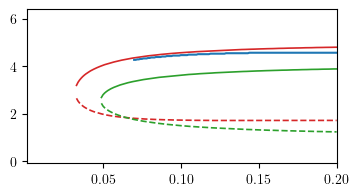

In [72]:
fig,axs = plt.subplots(figsize=(4,2))

add_diagram_1d(axs,a21_p1,del21_p1,(.001,.2,200),rhs=rhs_avg_1df)
add_diagram_1d(axs,a21_p1,del21_p1,(.001,.2,200),rhs=rhs_avg_1df,miter=1,color='tab:green')

axs.plot(erange,np.mod(-philist,2*np.pi))

<Axes: >

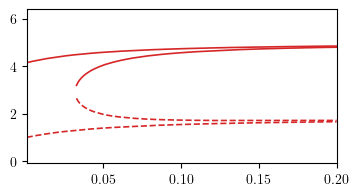

In [82]:
fig,axs = plt.subplots(figsize=(4,2))

add_diagram_1d(axs,a21_p1,.0,(.001,.2,200),rhs=rhs_avg_1df)
add_diagram_1d(axs,a21_p1,.01,(.001,.2,200),rhs=rhs_avg_1df)

In [124]:
init0 = np.array([-0.16936787,  0.94961894])
etupu = (.04,.02,-.01)
phi0 = 1.9
out = load_bif1d_f_u(_full_cgl1,a21_p1b,del21_p1b,etup=etupu,recompute=False,use_point=init0)
philist = load_phis_force_u(_full_cgl1,a21_p1b,del21_p1b,etup=etupu,period_multiple=10,recompute=False,use_point=init0)
print('phi',np.mod(-philist,2*np.pi)[0])
print('y',out[0])

etupu = (.05,.03,-.01)
out = load_bif1d_f_u(_full_cgl1,a21_p1b,del21_p1b,etup=etupu,recompute=True,use_point=out[0][1:])
philist = load_phis_force_u(_full_cgl1,a21_p1b,del21_p1b,etup=etupu,period_multiple=10,recompute=True,use_point=out[0][1:])
print('phi',np.mod(-philist,2*np.pi)[0])
print('y',out[0])

phi0 in run_bif1d_f 0
yprev,est [-0.16936787  0.94961894] [-0.16936787  0.94961894]
0, eps=0.040 [-0.16936787  0.94961894]
yprev,est [-0.31245478  0.93219117] [-0.31245478  0.93219117]
1, eps=0.030 [-0.31245478  0.93219117]
phi0 in run_bif1d_f 0
yprev,est [-0.16936787  0.94961895] [-0.16936787  0.94961895]
0, eps=0.040 [-0.16936787  0.94961895]
yprev,est [-0.31245478  0.93219117] [-0.31245478  0.93219117]
1, eps=0.030 [-0.31245478  0.93219117]
phi 1.749773204107095
y [ 0.04       -0.16936787  0.94961894]
phi0 in run_bif1d_f 0
yprev,est [-0.11149186  0.93852517] [-0.11149186  0.93852517]
0, eps=0.050 [-0.11149186  0.93852517]
yprev,est [-0.16936787  0.94961895] [-0.16936787  0.94961895]
1, eps=0.040 [-0.16936787  0.94961895]
yprev,est [-0.31245478  0.93219117] [-0.31245478  0.93219117]
2, eps=0.030 [-0.31245478  0.93219117]
phi0 in run_bif1d_f 0
yprev,est [-0.11149186  0.93852517] [-0.11149186  0.93852517]
0, eps=0.050 [-0.11149186  0.93852517]
yprev,est [-0.16936787  0.94961895] [-0.16

### Sims

In [70]:
# coupling and init
eps21_p1 = 0.1
th_init21_p1 = 2

In [71]:
# sim params
dt = .01;T_p1=100
t21_p1 = np.arange(0,T_p1,dt)
args21_p1 = {'args':(a21_p1,eps21_p1,del21_p1),'t_eval':t21_p1,**kw_sim,'dense_output':True}

In [72]:
y0_p1 = a21_p1.system1.lc['dat'][int((th_init21_p1/(2*np.pi))*a21_p1.system1.TN),:]
args0 = [a21_p1,eps21_p1,del21_p1]

solf = _get_sol(_full_cgl1,y0_p1,t21_p1,args=args0,recompute=True)        
tp,fp = get_phase(t21_p1,solf,skipn=100,system1=a21_p1.system1)
force_phase = (a21_p1._m[1]+del21_p1)*tp
fp2 = np.mod(fp-a21_p1.om*force_phase,2*np.pi)

args1 = {'t_eval':t21_p1,'t_span':[0,t21_p1[-1]],'args':(*args0,),**kw_sim}
solr1d = solve_ivp(rhs_avg_1df,y0=[th_init21_p1],**args1)

args0 = [a21_p1,eps21_p1,del21_p1,1]
args1 = {'t_eval':t21_p1,'t_span':[0,t21_p1[-1]],'args':(*args0,),**kw_sim}
solr1d0 = solve_ivp(rhs_avg_1df,y0=[th_init21_p1],**args1)

### Plot Sims

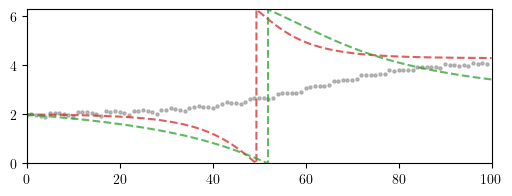

In [73]:
fig,axs = plt.subplots(1,1,figsize=(6,2))

# plot full sol
axs.scatter(tp,fp2,s=5,color='gray',alpha=.5,label='Full')
axs.set_ylim(0,2*np.pi)
axs.set_xlim(0,T_p1)

# 1d solution over time
axs.plot(t21_p1,np.mod(solr1d.y.T[:,0],2*np.pi),color='tab:red',alpha=.75,label='1D',ls='--')
axs.plot(t21_p1,np.mod(solr1d0.y.T[:,0],2*np.pi),color='tab:green',alpha=.75,label='1D',ls='--')

# 3:1

In [125]:
#recompute_list = ['h_data_cglf0','h_cglf0','p_cglf0','p_data_cglf0','k_cglf0','k_cglf1']
recompute_list = []
kw_nm = {'system1':system1,'system2':None,'_n':('om0',3),'_m':('om1',1),
         'NH':300,'save_fig':False,'recompute_list':recompute_list}

## del=0

In [126]:
del31_p0 = 0.0
a31_p0 = nm.nmCoupling(**kw_nm)
a31_p0.del1=del31_p0

Initializing 31 Coupling...
* Loading p...
p order=0
* Computing H cglf0, order=0...
p order=1
* Computing H cglf0, order=1...


### H functions

In [127]:
# aa = a31_p0
# fig,axs = plt.subplots(aa.system1.miter,1,figsize=(6,3))
# etemp = .05
# h = 0
# for k in range(aa.system1.miter):
#     axs[k].plot(aa.x,etemp**(k+1)*aa.system1.h['lam'][k](aa.x))
    
# plt.tight_layout()

### Plot 1par

In [128]:
out = load_bif1d_f(_full_cgl1,a31_p0,del31_p0,etup=(.002,.21,.01),max_iter=50,recompute=False)

phi0 in run_bif1d_f 0
0, eps=0.002 [-0.54575489 -0.84073344]
1, eps=0.012 [-0.48523999 -0.89059557]
2, eps=0.022 [-0.38056671 -0.95326463]
3, eps=0.032 [-0.18140676 -1.02242281]
4, eps=0.042 [ 0.20933521 -1.02399342]
5, eps=0.052 [ 0.73459734 -0.7226855 ]
6, eps=0.062 [ 0.96523431 -0.25598787]
7, eps=0.072 [0.97400543 0.01190851]
8, eps=0.082 [0.94659665 0.13813726]
9, eps=0.092 [0.921326   0.19851134]
10, eps=0.102 [0.90215622 0.22523274]
11, eps=0.112 [0.88814536 0.23209597]
12, eps=0.122 [0.87796229 0.22560911]
13, eps=0.132 [0.87049185 0.20911196]
14, eps=0.142 [0.86483092 0.18443705]
15, eps=0.152 [0.86020995 0.15265509]
16, eps=0.162 [0.85592664 0.11444438]
17, eps=0.172 [0.85130005 0.07028972]
18, eps=0.182 [0.84564023 0.02059511]
19, eps=0.192 [ 0.83822674 -0.03425382]
20, eps=0.202 [ 0.82828911 -0.09386244]


In [129]:
erange = out[:,0]
inits = out[:,1:]

In [130]:
philist = load_phis_force(_full_cgl1,a31_p0,del31_p0,etup=(.002,.21,.01),period_multiple=10)

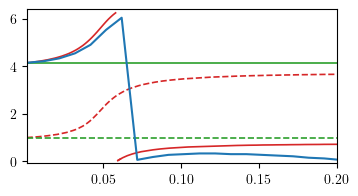

In [131]:
fig,axs = plt.subplots(figsize=(4,2))

add_diagram_1d(axs,a31_p0,del31_p0,(.001,.3,200),rhs=rhs_avg_1df)
add_diagram_1d(axs,a31_p0,del31_p0,(.001,.2,200),rhs=rhs_avg_1df,miter=1,color='tab:green')

axs.plot(erange,np.mod(-philist,2*np.pi))

### Unstable

In [171]:
etupu = (.001,.003,.001)
phi0 = .1
out = load_bif1d_f_u(_full_cgl1,a31_p0,del31_p0,etup=etupu,phi0=phi0,recompute=False)
philist = load_phis_force_u(_full_cgl1,a31_p0,del31_p0,etup=etupu,period_multiple=10,phi0=phi0,recompute=False)
print('phi',np.mod(-philist,2*np.pi)[-1])
print('y',out[-1])

etupu = (.003,.01,.001)
out = load_bif1d_f_u(_full_cgl1,a31_p0,del31_p0,etup=etupu,recompute=False,use_point=out[-1][1:])
philist = load_phis_force_u(_full_cgl1,a31_p0,del31_p0,etup=etupu,period_multiple=10,recompute=False,use_point=out[-1][1:])
print('phi',np.mod(-philist,2*np.pi)[-1])
print('y',out[-1])

etupu = (.01,.015,.001)
out = load_bif1d_f_u(_full_cgl1,a31_p0,del31_p0,etup=etupu,recompute=False,use_point=out[-1][1:])
philist = load_phis_force_u(_full_cgl1,a31_p0,del31_p0,etup=etupu,period_multiple=10,recompute=False,use_point=out[-1][1:])
print('phi',np.mod(-philist,2*np.pi)[-1])
print('y',out[-1])


etupu = (.015,.0,.001)
out = load_bif1d_f_u(_full_cgl1,a31_p0,del31_p0,etup=etupu,recompute=False,use_point=out[-1][1:])
philist = load_phis_force_u(_full_cgl1,a31_p0,del31_p0,etup=etupu,period_multiple=10,recompute=False,use_point=out[-1][1:])
print('phi',np.mod(-philist,2*np.pi)[-1])
print('y',out[-1])


phi 0.995559215387587
y [0.002      0.54423224 0.8361433 ]
phi 1.0555592153875892
y [0.009      0.49970307 0.853852  ]
phi0 in run_bif1d_f 0
yprev,est [0.49208073 0.85687055] [0.49208073 0.85687055]
0, eps=0.010 [0.49208073 0.85687055]
yprev,est [0.484069   0.86002505] [0.484069   0.86002505]
1, eps=0.011 [0.484069   0.86002505]
yprev,est [0.47563688 0.86332001] [0.47563688 0.86332001]
2, eps=0.012 [0.47563688 0.86332001]
yprev,est [0.46675041 0.86675963] [0.46675041 0.86675963]
3, eps=0.013 [0.46675041 0.86675963]
yprev,est [0.45737233 0.87034769] [0.45737233 0.87034769]
4, eps=0.014 [0.45737233 0.87034769]
phi 1.0855592153875904
y [0.014      0.45737233 0.87034769]


### Sims

In [ ]:
# coupling and init
eps31_p0 = 0.1
th_init31_p0 = 2

In [ ]:
# sim params
dt = .01;T_p001=100
t31_p0 = np.arange(0,T_p001,dt)
args31_p0 = {'args':(a31_p0,eps31_p0,del31_p0),'t_eval':t31_p0,**kw_sim,'dense_output':True}

In [ ]:
y0_p001 = a31_p0.system1.lc['dat'][int((th_init31_p0/(2*np.pi))*a31_p0.system1.TN),:]
args0 = [a31_p0,eps31_p0,del31_p0]

solf = _get_sol(_full_cgl1,y0_p001,t31_p0,args=args0,recompute=True)        
tp,fp = get_phase(t31_p0,solf,skipn=100,system1=a31_p0.system1)
force_phase = (a31_p0._m[1]+del31_p0)*tp
fp2 = np.mod(fp-a31_p0.om*force_phase,2*np.pi)

args1 = {'t_eval':t31_p0,'t_span':[0,t31_p0[-1]],'args':(*args0,),**kw_sim}
solr1d = solve_ivp(rhs_avg_1df,y0=[th_init31_p0],**args1)

args0 = [a31_p0,eps31_p0,del31_p0,1]
args1 = {'t_eval':t31_p0,'t_span':[0,t31_p0[-1]],'args':(*args0,),**kw_sim}
solr1d0 = solve_ivp(rhs_avg_1df,y0=[th_init31_p0],**args1)

### Plot Sims

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(6,2))

# plot full sol
axs.scatter(tp,fp2,s=5,color='gray',alpha=.5,label='Full')
axs.set_ylim(0,2*np.pi)
axs.set_xlim(0,T_p001)

# 1d solution over time
axs.plot(t31_p0,np.mod(solr1d.y.T[:,0],2*np.pi),color='tab:red',alpha=.75,label='1D',ls='--')
axs.plot(t31_p0,np.mod(solr1d0.y.T[:,0],2*np.pi),color='tab:green',alpha=.75,label='1D',ls='--')

## del=0.008

In [ ]:
del31_p1 = 0.008
a31_p1 = nm.nmCoupling(**kw_nm)
a31_p1.del1=del31_p1

### H functions

In [ ]:
# aa = a31_p1
# fig,axs = plt.subplots(aa.system1.miter+1,1,figsize=(6,3))
# etemp = .05
# h = 0
# for k in range(aa.system1.miter):
#     axs[k].plot(aa.x,aa.system1.h['lam'][k](aa.x/3))
#     h += etemp**(k+1)*aa.system1.h['lam'][k](aa.x/3)

# axs[-1].plot(h)
# plt.tight_layout()

### Plot 1par

In [ ]:
out = load_bif1d_f(_full_cgl1,a31_p1,del31_p1,etup=(.067,.201,.001),max_iter=25)

In [ ]:
erange = out[:,0]
inits = out[:,1:]

In [ ]:
philist = load_phis_force(_full_cgl1,a31_p1,del31_p1,etup=(.067,.201,.001),period_multiple=10)

In [ ]:
fig,axs = plt.subplots(figsize=(4,2))

add_diagram_1d(axs,a31_p1,del31_p1,(.06,.2,200),rhs=rhs_avg_1df)
add_diagram_1d(axs,a31_p1,del31_p1,(.06,.2,200),rhs=rhs_avg_1df,miter=1,color='tab:green')

axs.plot(erange,np.mod(-philist,2*np.pi))

### Sims

In [ ]:
# coupling and init
eps31_p1 = 0.1
th_init31_p1 = 2

In [ ]:
# sim params
dt = .01;T_p008=100
t31_p1 = np.arange(0,T_p008,dt)
args31_p1 = {'args':(a31_p1,eps31_p1,del31_p1),'t_eval':t31_p1,**kw_sim,'dense_output':True}

In [ ]:
y0_p008 = a31_p1.system1.lc['dat'][int((th_init31_p1/(2*np.pi))*a31_p1.system1.TN),:]
args0 = [a31_p1,eps31_p1,del31_p1]

solf = _get_sol(_full_cgl1,y0_p008,t31_p1,args=args0,recompute=True)        
tp,fp = get_phase(t31_p1,solf,skipn=100,system1=a31_p1.system1)
force_phase = (a31_p1._m[1]+del31_p1)*tp
fp2 = np.mod(fp-a31_p1.om*force_phase,2*np.pi)

args1 = {'t_eval':t31_p1,'t_span':[0,t31_p1[-1]],'args':(*args0,),**kw_sim}
solr1d = solve_ivp(rhs_avg_1df,y0=[th_init31_p1],**args1)

args0 = [a31_p1,eps31_p1,del31_p1,1]
args1 = {'t_eval':t31_p1,'t_span':[0,t31_p1[-1]],'args':(*args0,),**kw_sim}
solr1d0 = solve_ivp(rhs_avg_1df,y0=[th_init31_p1],**args1)

### Plot Sims

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(6,2))

axs.scatter(tp,fp2,s=5,color='gray',alpha=.5,label='Full')

axs.plot(t31_p1,np.mod(solr1d.y.T[:,0],2*np.pi),color='tab:red',alpha=.75,label='1D',ls='--')
axs.plot(t31_p1,np.mod(solr1d0.y.T[:,0],2*np.pi),color='tab:green',alpha=.75,label='1D',ls='--')

# 4:1

In [ ]:
recompute_list = ['h_data_cglf0','h_cglf0','p_cglf0','p_data_cglf0','k_cglf0','k_cglf1']
#recompute_list = []
kw_nm = {'system1':system1,'system2':None,'_n':('om0',4),'_m':('om1',1),
         'NH':500,'save_fig':False,'recompute_list':recompute_list}

## del=0.0

In [ ]:
del41_p0 = 0.0
a41_p0 = nm.nmCoupling(**kw_nm)
a41_p0.del1=del41_p0

### H functions

In [ ]:
# aa = a41_p0
# fig,axs = plt.subplots(aa.system1.miter+1,1,figsize=(6,3))
# etemp = .05
# h = 0
# for k in range(aa.system1.miter):
#     axs[k].plot(aa.x,aa.system1.h['lam'][k](aa.x/4))
#     h += etemp**(k+1)*aa.system1.h['lam'][k](aa.x/4)

# axs[-1].plot(h)
# plt.tight_layout()

### Plot 1par

In [ ]:
out = load_bif1d_f(_full_cgl1,a41_p0,del41_p0,etup=(.002,.11,.01),max_iter=50)

In [ ]:
erange = out[:,0]
inits = out[:,1:]

In [ ]:
philist = load_phis_force(_full_cgl1,a41_p0,del41_p0,etup=(.002,.11,.01),period_multiple=10)

In [ ]:
fig,axs = plt.subplots(figsize=(4,2))

add_diagram_1d(axs,a41_p0,del41_p0,(.001,.1,200),rhs=rhs_avg_1df)
add_diagram_1d(axs,a41_p0,del41_p0,(.001,.1,200),rhs=rhs_avg_1df,miter=1,color='tab:green')

axs.plot(erange,np.mod(-philist,2*np.pi))

### Sims

In [ ]:
# coupling and init
eps41_p0 = 0.06
th_init41_p0 = 2

In [ ]:
# sim params
dt = .01;T_p01=100
t41_p0 = np.arange(0,T_p01,dt)
args41_p0 = {'args':(a41_p0,eps41_p0,del41_p0),'t_eval':t41_p0,**kw_sim,'dense_output':True}

In [ ]:
y0_p01 = a41_p0.system1.lc['dat'][int((th_init41_p0/(2*np.pi))*a41_p0.system1.TN),:]
args0 = [a41_p0,eps41_p0,del41_p0]

solf = _get_sol(_full_cgl1,y0_p01,t41_p0,args=args0,recompute=True)        
tp,fp = get_phase(t41_p0,solf,skipn=100,system1=a41_p0.system1)
force_phase = (a41_p0._m[1]+del41_p0)*tp
fp2 = np.mod(fp-a41_p0.om*force_phase,2*np.pi)

args1 = {'t_eval':t41_p0,'t_span':[0,t41_p0[-1]],'args':(*args0,),**kw_sim}
solr1d = solve_ivp(rhs_avg_1df,y0=[th_init41_p0],**args1)

args0 = [a41_p0,eps41_p0,del41_p0,1]
args1 = {'t_eval':t41_p0,'t_span':[0,t41_p0[-1]],'args':(*args0,),**kw_sim}
solr1d0 = solve_ivp(rhs_avg_1df,y0=[th_init41_p0],**args1)

### Plot Sims

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(6,2))

# plot full sol
axs.scatter(tp,fp2,s=5,color='gray',alpha=.5,label='Full')
axs.set_ylim(0,2*np.pi)

# 1d solution over time
axs.plot(t41_p0,np.mod(solr1d.y.T[:,0],2*np.pi),color='tab:red',alpha=.75,label='1D',ls='--')
axs.plot(t41_p0,np.mod(solr1d0.y.T[:,0],2*np.pi),color='tab:green',alpha=.75,label='1D',ls='--')

## del=0.0007

In [ ]:
del41_p1 = 0.0007
a41_p1 = nm.nmCoupling(**kw_nm)
a41_p1.del1=del41_p1

### H functions

In [ ]:
# aa = a41_p1
# fig,axs = plt.subplots(aa.system1.miter,1,figsize=(6,3))
# etemp = .05
# h = 0
# for k in range(aa.system1.miter):
#     axs[k].plot(aa.x,etemp**(k+1)*aa.system1.h['lam'][k](aa.x))
    
# plt.tight_layout()

### Plot

In [ ]:
out = load_bif1d_f(_full_cgl1,a41_p1,del41_p1,etup=(.015,.101,.001),max_iter=50)

In [ ]:
erange = out[:,0]
inits = out[:,1:]

In [ ]:
philist = load_phis_force(_full_cgl1,a41_p1,del41_p1,etup=(.015,.101,.001),period_multiple=10)

In [ ]:
fig,axs = plt.subplots(figsize=(4,2))

add_diagram_1d(axs,a41_p1,del41_p1,(.001,.1,200),rhs=rhs_avg_1df)
add_diagram_1d(axs,a41_p1,del41_p1,(.001,.1,200),rhs=rhs_avg_1df,miter=1,color='tab:green')

axs.plot(erange,np.mod(-philist,2*np.pi))

### Sims

In [ ]:
# coupling and init
eps41_p1 = 0.06
th_init41_p1 = 3

In [ ]:
# sim params
dt = .01;T_p01=5000
t41_p1 = np.arange(0,T_p01,dt)
args41_p1 = {'args':(a41_p1,eps41_p1,del41_p1),
             't_eval':t41_p1,**kw_sim,'dense_output':True}

In [ ]:
y0_p01 = a41_p1.system1.lc['dat'][int((th_init41_p1/(2*np.pi))*a41_p1.system1.TN),:]
args0 = [a41_p1,eps41_p1,del41_p1]

solf = _get_sol(_full_cgl1,y0_p01,t41_p1,args=args0,recompute=True)        
tp,fp = get_phase(t41_p1,solf,skipn=100,system1=a41_p1.system1)
force_phase = (a41_p1._m[1]+del41_p1)*tp
fp2 = np.mod(fp-a41_p1.om*force_phase,2*np.pi)

args1 = {'t_eval':t41_p1,'t_span':[0,t41_p1[-1]],'args':(*args0,),**kw_sim}
solr1d = solve_ivp(rhs_avg_1df,y0=[th_init41_p1],**args1)

args0 = [a41_p1,eps41_p1,del41_p1,1]
args1 = {'t_eval':t41_p1,'t_span':[0,t41_p1[-1]],'args':(*args0,),**kw_sim}
solr1d0 = solve_ivp(rhs_avg_1df,y0=[th_init41_p1],**args1)

### Plot Sims

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(6,2))

# plot full sol
axs.scatter(tp,fp2,s=5,color='gray',alpha=.5,label='Full')
axs.set_ylim(0,2*np.pi)
axs.set_xlim(0,T_p01)

# 1d solution over time
axs.plot(t41_p1,np.mod(solr1d.y.T[:,0],2*np.pi),color='tab:red',alpha=.75,label='1D',ls='--')
axs.plot(t41_p1,np.mod(solr1d0.y.T[:,0],2*np.pi),color='tab:green',alpha=.75,label='1D',ls='--')